In [517]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import scipy
import pickle
from scipy.stats import poisson
import pymc as pm

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [518]:
# First load the data 

hdulist1 = fits.open('/Users/jmartine/science/data/clusters_morales/images/02713-K.fits')
hdulist2 = fits.open('/Users/jmartine/science/data/clusters_morales/images/02713-I3.fits')

bkg = 26.0

im_K = hdulist1[0].data
im_I1 = np.array(hdulist2[0].data[4:15,3:14]) - bkg

print np.min(im_I1)

im_I1[im_I1 < 0.0] = 0.0

-2.242


0.0 151.598


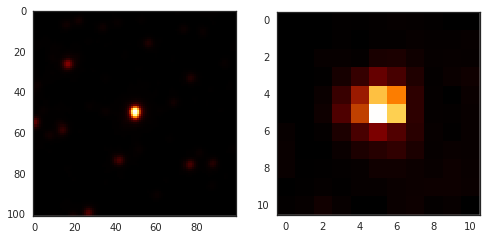

In [519]:
cmap = 'afmhot'
plt.subplots(1,2,figsize=(8,12))
plt.subplot(1,2,1)
plt.imshow(im_K, interpolation='None',cmap=cmap)
plt.subplot(1,2,2)
mini = np.min(im_I1)
maxi = np.max(im_I1)
plt.imshow(im_I1, interpolation='None',vmin=mini,vmax=maxi,cmap=cmap)

print mini,maxi

In [520]:
# Number of pixels
M = im_I1.size

#print len(im_I1[:,0])

# Width of the grid element
w = 1.0

# Array of coordinates
X = []
counts = []

for i in arange(len(im_I1[:,0])):
    for j in arange(len(im_I1[0,:])):
        X.append([i,j])
        counts.append(im_I1[i,j])

X =  np.array(X)
counts = np.array(counts)


# The measured values are the fluxes in each pixel. In the Chicago example, this corresponds to counts.

#print X,counts

print centers[0]

[ 5.5422586  5.9591855]


In [521]:
# Parameters uf the Gaussians
centers = np.array([[9.5422586-4,8.9591855-3],[9.2019312-4,8.8068763-3],[9.09967-4,7.6253037-3]])-0.5
#sigma = [[[0.36,0],[0,0.36]],[[0.36,0],[0,0.36]],[[0.36,0],[0,0.36]]]
sigma = [[0.45,0],[0,0.45]]
tau = np.linalg.inv(sigma)

print centers[0]

[ 5.0422586  5.4591855]


In [522]:
##print np.exp(-0.5*transpose(X[0]-centers[0])*tau[0]*(X[0]-centers[0]))

mixture0 = []
mixture1 = []
mixture2 = []

for i in range(0,M):
    mixture0.append(np.exp(-0.5*transpose(X[i]-centers[0]).dot(tau).dot(X[i]-centers[0])))
    mixture1.append(np.exp(-0.5*transpose(X[i]-centers[1]).dot(tau).dot(X[i]-centers[1])))
    mixture2.append(np.exp(-0.5*transpose(X[i]-centers[2]).dot(tau).dot(X[i]-centers[2])))

mixture0 = np.array(mixture0)
mixture1 = np.array(mixture1)
mixture2 = np.array(mixture2)

print shape(mixture0)
#Tau = np.array(Tau)
    
#Z0 = Z[:,0,:]
#Z1 = Z[:,1,:]
#Z2 = Z[:,2,:]

#print shape(Tau)
#print shape(Z1)

#print tau

#print X-centers[0]
#print centers[1]

#D = pm.MvNormal(name='MVN0', mu=mu[0], tau=tau[0]) + pm.MvNormal(name='MVN1', mu=mu[1], tau=tau[1]) +\
#pm.MvNormal(name='MVN2', mu=mu[2], tau=tau[2])
#D1 = pm.MvNormal(name='MVN1', mu=mu[1], tau=tau[1])
#D2 = pm.MvNormal(name='MVN2', mu=mu[2], tau=tau[2])
#D = D0 + D1 + D2

(121,)


In [523]:
# priors must be on the paramters of the Gaussians

import pymc as pm

A0 = pm.Uniform(name='A0', lower=log10(0.1), upper=log10(1000))
A1 = pm.Uniform(name='A1', lower=log10(0.1), upper=log10(1000))
A2 = pm.Uniform(name='A2', lower=log10(0.1), upper=log10(1000))


#D = pm.MvNormal(name='MVN0', mu=mu[0], tau=tau[0]) + pm.MvNormal(name='MVN1', mu=mu[1], tau=tau[1]) +\
#pm.MvNormal(name='MVN2', mu=mu[2], tau=tau[2])

@pm.deterministic
def lambdas(A0 = A0, A1 = A1, A2 = A2, w=1.0):

    return ((10.0**A0)*mixture0+(10.0**A1)*mixture1+(10.0**A2)*mixture2)*(w**2)

likelihood = pm.Poisson(name='likelihood', mu=lambdas, value=counts, observed=True)

In [524]:
m = pm.Model([A0, A1, A2, lambdas, likelihood])
mc = pm.MCMC(m)
mc.sample(iter=100000, burn=20000)

 [-----------------100%-----------------] 100000 of 100000 complete in 15.6 sec

Plotting A1


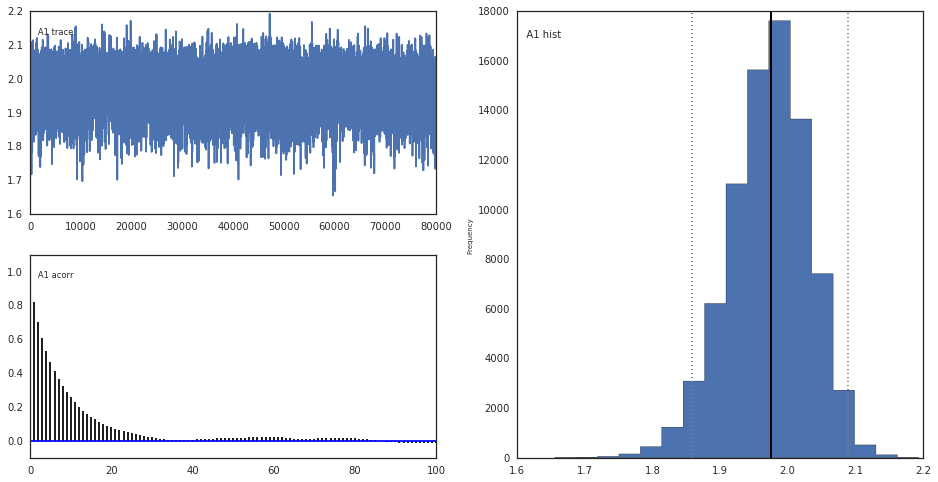

In [525]:
fig = plt.figure(figsize=(16,8))
pm.Matplot.plot(A1, new=False)
plt.savefig('posterior.ps')

In [526]:
import seaborn as sns
sns.set_style("white")
def plot_counts(counts):
    cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
    #colors = counts / np.double(np.max(counts))
    colors = counts
    print shape(colors)
    #plt.contour(colors)
    #CS = plt.scatter(X[:,0], X[:,1], s=250, c=colors, cmap='YlOrRd', edgecolors='none')
    colors = reshape(colors,(11,11),'F')
    plt.subplots(1,2,figsize=(10,5))
    plt.subplot(1,2,1)
    for i in arange(len(centers)): plt.plot(centers[i][0],centers[i][1],marker='+',color='red',ms=10,mew=2)
    CS = plt.imshow(colors.T,interpolation='None',cmap=cmap)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    CB.set_label('Flux density [MJy/sr]',size=15)
    #plt.xlabel('RA',size=20)
    #plt.ylabel('Dec',size=20)
    plt.title('Simulated image',size=20)
    plt.text(0.0,1,'ID 2713',size=15,color='white')
    plt.text(4.7,9,'1 pixel = 1.2"',size=15,color='white')
    plt.text(1.9,10,'IRAC1, FWHM = 1.7"',size=15,color='white')
    plt.subplot(1,2,2)
    for i in arange(len(centers)): plt.plot(centers[i][0],centers[i][1],marker='+',color='red',ms=10,mew=2)
    CS1 = plt.imshow(im_I1, interpolation='None',vmin=mini,vmax=maxi,cmap=cmap)
    CB1 = plt.colorbar(CS1, shrink=0.8, extend='both')
    CB1.set_label('Flux density [MJy/sr]',size=15)
    #plt.xlabel('RA',size=20)
    #plt.ylabel('Dec',size=20)
    plt.title('Measured image',size=20)
    plt.text(0.0,1,'ID 2713',size=15,color='white')
    plt.text(4.7,9,'1 pixel = 1.2"',size=15,color='white')
    plt.text(1.9,10,'IRAC1, FWHM = 1.7"',size=15,color='white')
    plt.savefig('posterior_image.png',dpi=300,bbox_inches='tight')
    plt.savefig('posterior_image.ps',dpi=300,bbox_inches='tight')
    plt.savefig('posterior_image.pdf',dpi=300,bbox_inches='tight')

(121,)


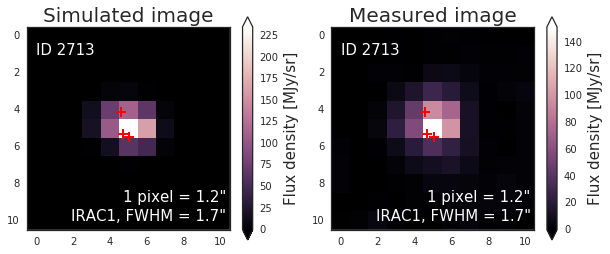

In [527]:
posterior_pymc = np.mean(lambdas.trace(), axis=0)
plot_counts(posterior_pymc)

In [245]:
#@pm.deterministic
#def lambdas(Z=D0+D1+D2, w=1.0):
#    return Z*(w**2)

#likelihood = pm.Poisson(name='likelihood', mu=lambdas, value=im_I1, observed=True)